# GenAI with Python: AI Agents from Zero to Hero

###### [Article (Part 1): TowardsDataScience]()

## 0 - Setup

In [1]:
#pip install ollama==0.4.7
import ollama
llm = "qwen2.5" 

In [68]:
stream = ollama.generate(model=llm, prompt='''what time is it?''', stream=True)
for chunk in stream:
    print(chunk['response'], end='', flush=True)

To provide you with the current time, I would need to know your location or timezone since "time" can refer to different times in different parts of the world. Could you please tell me which timezone you're interested in? If you just want a general idea, you can check your device's clock for the current time.

## 1 - Single Agent

### 1.1 - Simple (WebSearch)

In [3]:
#pip install langchain-community==0.3.17
#pip install duckduckgo_search==6.3.5
from langchain_community.tools import DuckDuckGoSearchResults 

def search_web(query: str) -> str:
  return DuckDuckGoSearchResults(backend="news").run(query)

tool_search_web = {'type':'function', 'function':{
  'name': 'search_web',
  'description': 'Search the web',
  'parameters': {'type': 'object', 
                 'required': ['query'],
                 'properties': {
                    'query': {'type':'str', 'description':'the topic or subject to search on the web'},
}}}}
## test
search_web(query="nvidia")

"snippet: Trump officials are probing whether China's DeepSeek bought advanced Nvidia semiconductors through third parties in Singapore., title: Singapore buys only small amount of Nvidia chips, official says, link: https://www.msn.com/en-us/money/other/singapore-buys-only-small-amount-of-nvidia-chips-official-says/ar-AA1zgsRV, date: 2025-02-18T11:43:00+00:00, source: Bloomberg on MSN.com, snippet: Nvidia's stock took a major hit last month with the debut of Chinese AI chatbot DeepSeek. Its makers claimed it could do the work of American chatbots but for a much smaller price, title: Nvidia shocks investors, buys and sells popular AI stocks, link: https://www.msn.com/en-us/money/companies/nvidia-shocks-investors-buys-and-sells-popular-ai-stocks/ar-AA1zdSYr, date: 2025-02-17T16:07:00+00:00, source: TheStreet on MSN.com, snippet: Nvidia (NVDA 2.63%) shares have advanced 180% since January 2024 amid incredible demand for its artificial intelligence platforms. But billionaire Israel England

In [4]:
def search_yf(query: str) -> str:
  return DuckDuckGoSearchResults(backend="news").run(f"site:finance.yahoo.com {query}")

tool_search_yf = {'type':'function', 'function':{
  'name': 'search_yf',
  'description': 'Search for specific financial news',
  'parameters': {'type': 'object', 
                 'required': ['query'],
                 'properties': {
                    'query': {'type':'str', 'description':'the financial topic or subject to search'},
}}}}
## test
search_yf(query="nvidia")

'snippet: We recently compiled a list of the Jim Cramer Discusses These 11 Stocks & Finds Few Reasons To Sell. In this article, we are going to take a look at where NVIDIA Corporation (NASDAQ:NVDA) stands against the other stocks., title: Jim Cramer on NVIDIA (NVDA): \'I Think You Have To Wait To See What The Numbers Are Because The Company\'s In Quiet Period\', link: https://finance.yahoo.com/news/jim-cramer-nvidia-nvda-think-115144647.html, date: 2025-02-18T11:51:00+00:00, source: YAHOO!Finance, snippet: To be specific, Meta is preparing to spend up to $65 billion in AI infrastructure this year -- representing a 65% increase year over year. Given the company works closely with Nvi, title: Did Meta Platforms Just Say "Checkmate" to Nvidia?, link: https://finance.yahoo.com/news/did-meta-platforms-just-checkmate-120000327.html, date: 2025-02-18T12:00:00+00:00, source: YAHOO!Finance, snippet: Nvidia (NASDAQ: NVDA) shares have advanced 180% since January 2024 amid incredible demand for it

In [19]:
prompt = '''You are an assistant with access to tools, you must decide when to use tools to answer user message.''' 
messages = [{"role":"system", "content":prompt}]

while True:
    ## user input
    try:
        q = input('🙂 >')
    except EOFError:
        break
    if q == "quit":
        break
    if q.strip() == "":
        continue
    messages.append( {"role":"user", "content":q} )
    
    ## model
    agent_res = ollama.chat(
        model=llm,
        #format="json", #or schema
        stream=False,
        tools=[tool_search_web, tool_search_yf],
        messages=messages)
  
    ## response
    dic_tools = {'search_web':search_web, 'search_yf':search_yf}

    if "tool_calls" in agent_res["message"].keys():
        for tool in agent_res["message"]["tool_calls"]:
            t_name, t_inputs = tool["function"]["name"], tool["function"]["arguments"]
            if f := dic_tools.get(t_name):
                ### calling tool
                print('🔧 >', f"\x1b[1;31m{t_name} -> Inputs: {t_inputs}\x1b[0m")
                messages.append( {"role":"user", "content":"use tool '"+t_name+"' with inputs: "+str(t_inputs)} )
                ### tool output
                t_output = f(**tool["function"]["arguments"])
                print(t_output)
                ### final res
                p = f'''Summarize this to answer user question, be as concise as possible: {t_output}'''
                res = ollama.generate(model=llm, prompt=q+". "+p)["response"]
            else:
                print('🤬 >', f"\x1b[1;31m{t_name} -> NotFound\x1b[0m")
  
    if agent_res['message']['content'] != '':
        res = agent_res["message"]["content"]
      
    print("👽 >", f"\x1b[1;30m{res}\x1b[0m")
    messages.append( {"role":"assistant", "content":res} )

🙂 > hi


👽 > Hello! How can I assist you today?


🙂 > tell me about Powell


🔧 > search_web -> Inputs: {'query': 'Powell'}
snippet: Norman Powell scored a season-high 41 points and James Harden added 32 to lift the Los Angeles Clippers to a 120-116 overtime victory over the Utah Jazz on Thursday night. Harden also had 10 rebounds,, title: Powell scores 41 points, Harden has 32 to rally Clippers to 120-116 OT victory over Jazz, link: https://www.msn.com/en-us/sports/other/powell-scores-41-points-harden-has-32-to-rally-clippers-to-120-116-ot-victory-over-jazz/ar-AA1z1Avi, date: 2025-02-14T05:07:00+00:00, source: MSN, snippet: Federal Reserve Chair Jerome Powell said the latest consumer price data show that while the central bank has made substantial progress toward taming inflation, there is still more work to do., title: Powell Says New Inflation Data Show Fed Has More Work to Do, link: https://www.bloomberg.com/news/articles/2025-02-12/powell-says-latest-inflation-data-show-fed-has-more-work-to-do, date: 2025-02-12T16:26:00+00:00, source: Bloomberg L.P., snippe

🙂 > be more specific about the rate cut


🔧 > search_yf -> Inputs: {'query': 'Jerome Powell rate cut'}
snippet: Federal Reserve Chair Jerome Powell will tell the Senate banking committee the Fed isn't "in a hurry" to resume its interest rate cutting campaign., title: Powell says Fed not 'in a hurry' to cut interest rates with 'economy remaining strong', link: https://finance.yahoo.com/news/powell-says-fed-not-hurry-150310004.html, date: 2025-02-11T15:03:00+00:00, source: YAHOO!Finance, snippet: Treasuries fell as traders anticipate that Federal Reserve Chair Jerome Powell will reiterate that US interest rates are on hold in congressional testimony Tuesday. Most Read from BloombergSaudi Arabia's Neom Signs $5 Billion Deal for AI Data CenterNice Airport,, title: Treasuries Fall as Fed's Powell Affirms Patience on Rate Cuts, link: https://finance.yahoo.com/news/treasuries-slip-tariffs-dominating-powell-111714559.html, date: 2025-02-11T14:18:00+00:00, source: YAHOO!Finance, snippet: Just before the release of Wednesday's monthly c

🙂 > quit


In [20]:
messages

[{'role': 'system',
  'content': 'You are an assistant with access to tools, you must decide when to use tools to answer user message.'},
 {'role': 'user', 'content': 'hi'},
 {'role': 'assistant', 'content': 'Hello! How can I assist you today?'},
 {'role': 'user', 'content': 'tell me about Powell'},
 {'role': 'assistant',
  'content': "The snippets provide information about Jerome Powell's statements and actions in February 2025:\n\n1. Norman Powell scored 41 points, James Harden added 32, helping the Los Angeles Clippers defeat the Utah Jazz in overtime.\n\n2. Jerome Powell stated that while significant progress has been made in taming inflation, more work is needed based on recent consumer price data.\n\n3. Powell testified before a Senate committee about monetary policy and denied any attempts by Elon Musk or his team to access Fed systems.\n\n4. Higher inflation readings led to Powell informing lawmakers, business executives, and the public that they might need to wait longer for r

In [21]:
agent_res

{'model': 'qwen2.5',
 'created_at': '2025-02-14T12:56:42.282608Z',
 'message': {'role': 'assistant',
  'content': '',
  'tool_calls': [{'function': {'name': 'search_yf',
     'arguments': {'query': 'Jerome Powell rate cut'}}}]},
 'done_reason': 'stop',
 'done': True,
 'total_duration': 47726659663,
 'load_duration': 30518855,
 'prompt_eval_count': 525,
 'prompt_eval_duration': 39558000000,
 'eval_count': 59,
 'eval_duration': 8102000000}

### 1.2 - Advanced (Coding)

###### What I want

In [6]:
import pandas as pd

dtf = pd.read_csv('http://bit.ly/kaggletrain')
dtf.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


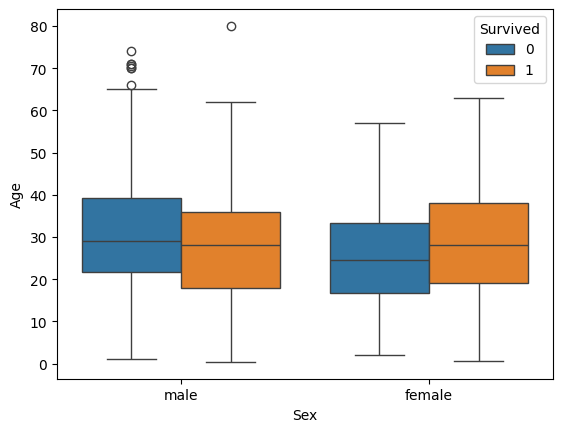

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=dtf, x="Sex", y="Age", hue="Survived")
plt.show()

###### Model

In [75]:
import io
import contextlib

def code_exec(code: str) -> str:
    output = io.StringIO()
    with contextlib.redirect_stdout(output):
        try:
            exec(code)
        except Exception as e:
            print(f"Error: {e}")
    return output.getvalue()

tool_code_exec = {'type':'function', 'function':{
  'name': 'code_exec',
  'description': 'execute python code',
  'parameters': {'type': 'object', 
                 'required': ['code'],
                 'properties': {
                    'code': {'type':'str', 'description':'code to execute'},
}}}}

code_exec("a=1+1; print(a)")

'2\n'

📁 Provide a CSV path > http://bit.ly/kaggletrain


🔧 > code_exec -> Inputs: {'code': 'import pandas as pd; df=pd.read_csv("http://bit.ly/kaggletrain"); print(df.head())'}
👽 >    PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250  

🙂 > create a boxplot with the columns 'Sex' and 'Age' and use the column 'Survived' for color


🔧 > code_exec -> Inputs: {'code': 'import matplotlib.pyplot as plt; import seaborn as sns; import pandas as pd; df = pd.read_csv("http://bit.ly/kaggletrain"); sns.boxplot(x=df[\'Sex\'], y=df[\'Age\'], hue=df[\'Survived\']); plt.show()'}


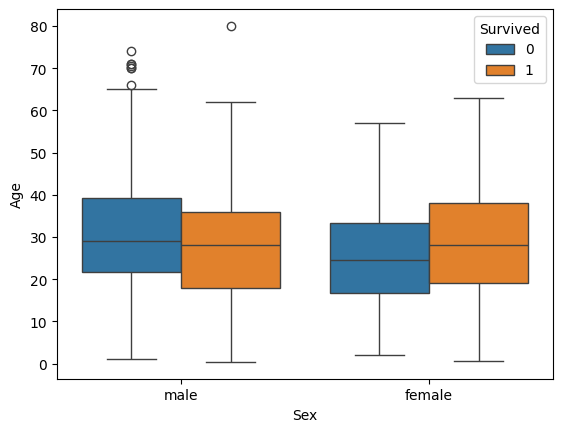

👽 > 


🙂 > quit


In [68]:
prompt = '''You are an expert data scientist, and you have tools to execute python code.
First of all, execute the following code exactly as it is: 'df=pd.read_csv(path); print(df.head())'
If you create a plot, ALWAYS add 'plt.show()' at the end.
'''
messages = [{"role":"system", "content":prompt}]
memory = '''Use the dataframe 'df'.'''
start = True

while True:
    ## user input
    try:
        if start is True:
            path = input('📁 Provide a CSV path >')
            q = "path = "+path
        else:
            q = input('🙂 >')
    except EOFError:
        break
    if q == "quit":
        break
    if q.strip() == "":
        continue
    
    ## memory
    if start is False:
        q = memory+"\n"+q
    messages.append( {"role":"user", "content":q} )

    ## model
    agent_res = ollama.chat(
        model=llm,
        #format="json", #or schema
        stream=False,
        tools=[tool_code_exec],
        messages=messages)
  
    ## response
    dic_tools = {'code_exec':code_exec}
    
    if "tool_calls" in agent_res["message"].keys():
        for tool in agent_res["message"]["tool_calls"]:
            t_name, t_inputs = tool["function"]["name"], tool["function"]["arguments"]
            if f := dic_tools.get(t_name):
                ### calling tool
                print('🔧 >', f"\x1b[1;31m{t_name} -> Inputs: {t_inputs}\x1b[0m")
                messages.append( {"role":"user", "content":"use tool '"+t_name+"' with inputs: "+str(t_inputs)} )
                ### tool output
                t_output = f(**tool["function"]["arguments"])
                ### final res
                res = t_output
            else:
                print('🤬 >', f"\x1b[1;31m{t_name} -> NotFound\x1b[0m")
  
    if agent_res['message']['content'] != '':
        res = agent_res["message"]["content"]
      
    print("👽 >", f"\x1b[1;30m{res}\x1b[0m")
    messages.append( {"role":"assistant", "content":res} )
    start = False

In [69]:
messages

[{'role': 'system',
  'content': "You are an expert data scientist, and you have tools to write and execute python code.\nFirst of all, use the tool to execute the following code exactly like this: 'df=pd.read_csv(path); print(df.head())'\nRight after you use the tool to generate code, you MUST ALWAYS use also the tool to execute the code you generated.\n"},
 {'role': 'user', 'content': 'path = http://bit.ly/kaggletrain'},
 {'role': 'user',
  'content': 'use tool \'code_exec\' with inputs: {\'code\': \'import pandas as pd; df=pd.read_csv("http://bit.ly/kaggletrain"); print(df.head())\'}'},
 {'role': 'assistant',
  'content': '   PassengerId  Survived  Pclass  \\\n0            1         0       3   \n1            2         1       1   \n2            3         1       3   \n3            4         1       1   \n4            5         0       3   \n\n                                                Name     Sex   Age  SibSp  \\\n0                            Braund, Mr. Owen Harris    male  

## 2 - Multi-Agents

### 2.1 - Simple (Sequential)

### 2.2 - Advanced (Hierarchical)